In [88]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torch.autograd import Variable
from torch import distributions as dist

from legged_gym.algorithm.terrain_encoder.swae_model import SWAE, LatentSpaceMapper, TestMapper

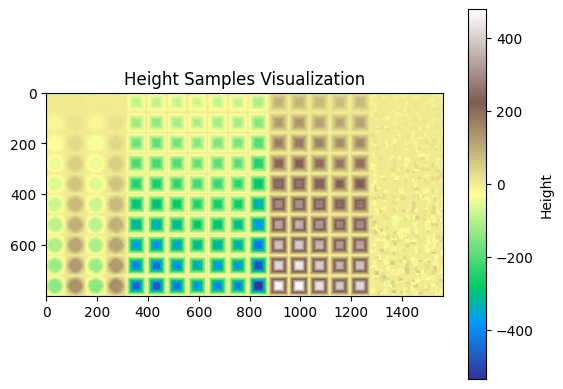

In [89]:
# 读取npy文件
heights = np.load('/home/zhengkr/limx_rl/pointfoot-legged-gym/legged_gym/algorithm/terrain_encoder/terrain.npy')

# 可视化
plt.imshow(heights, cmap='terrain')
plt.colorbar(label='Height')
plt.title('Height Samples Visualization')
plt.show()

In [ ]:
@torch.jit.script
def normalize(x, eps: float = 1e-9):
    return x / x.norm(p=2, dim=-1).clamp(min=eps, max=None).unsqueeze(-1)

@torch.jit.script
def quat_apply(a, b):
    shape = b.shape
    a = a.reshape(-1, 4)
    b = b.reshape(-1, 3)
    xyz = a[:, :3]
    t = xyz.cross(b, dim=-1) * 2
    return (b + a[:, 3:] * t + xyz.cross(t, dim=-1)).view(shape)

def quat_apply_yaw(quat, vec):
    quat_yaw = quat.clone().view(-1, 4)
    quat_yaw[:, :2] = 0.0
    quat_yaw = normalize(quat_yaw)
    return quat_apply(quat_yaw, vec)

In [91]:
class BipedCfgPF():

    class env:
        num_envs = 8192
        num_observations = 30  # 更新：移除了相对目标位置，现在obs_buf是30维
        num_critic_observations = 3 + num_observations  # critic还包含3维线性速度
        num_height_samples = 117
        num_actions = 6
        env_spacing = 3.0  # not used with heightfields/trimeshes
        send_timeouts = True  # send time out information to the algorithm
        episode_length_s = 20  # episode length in seconds
        obs_history_length = 10  # number of observations stacked together
        dof_vel_use_pos_diff = True
        fail_to_terminal_time_s = 0.5

    class terrain:
        mesh_type = "trimesh"  # "heightfield" # none, plane, heightfield or trimesh
        horizontal_scale = 0.1  # [m]
        vertical_scale = 0.005  # [m]
        border_size = 25  # [m]
        curriculum = True
        static_friction = 0.4
        dynamic_friction = 0.4
        restitution = 0.8
        # rough terrain only:
        measure_heights = False
        critic_measure_heights = True
        # 64 x 64 measurement grid (covers -3.15m to 3.15m with 0.1m spacing)
        measured_points_x = [round(x, 2) for x in np.linspace(-3.15, 3.15, 64)]
        measured_points_y = [round(y, 2) for y in np.linspace(-3.15, 3.15, 64)]
        selected = False  # select a unique terrain type and pass all arguments
        terrain_kwargs = None  # Dict of arguments for selected terrain
        max_init_terrain_level = 5 + 4  # starting curriculum state
        terrain_length = 8.0
        terrain_width = 8.0
        num_rows = 10  # number of terrain rows (levels)
        num_cols = 20  # number of terrain cols (types)
        # terrain types: [smooth slope, rough slope, stairs up, stairs down, discrete]
        terrain_proportions = [0.1, 0.1, 0.35, 0.25, 0.2]
        # trimesh only:
        slope_treshold = (
            0.75  # slopes above this threshold will be corrected to vertical surfaces
        )

        save_height_samples = True
        height_samples_path = "./terrain.npy"



In [92]:
class TerrainEncoderDataset(Dataset):
    def __init__(self, cfg: BipedCfgPF, device: str = "cuda"):
        self.cfg = cfg
        self.device = device

        # 加载高度图
        self.height_samples = torch.tensor(
            np.load(cfg.terrain.height_samples_path), device=self.device, requires_grad=False
        )  # (H,W)

        # (num_pts,3) 局部坐标 (base 框架)
        self.height_points = self._init_height_points()

        self.rows = len(self.cfg.terrain.measured_points_x)
        self.cols = len(self.cfg.terrain.measured_points_y)

        # 预计算安全采样范围
        H, W = self.height_samples.shape
        hs = self.cfg.terrain.horizontal_scale
        border = self.cfg.terrain.border_size

        local_xy = self.height_points[:, :2]  # (num_pts,2)
        max_r = torch.sqrt((local_xy ** 2).sum(dim=1)).max().item()

        max_x_phys = (H - 2) * hs - border
        max_y_phys = (W - 2) * hs - border
        min_x_phys = -border
        min_y_phys = -border

        self.safe_x_min = min_x_phys + max_r
        self.safe_x_max = max_x_phys - max_r
        self.safe_y_min = min_y_phys + max_r
        self.safe_y_max = max_y_phys - max_r

        if not (self.safe_x_min < self.safe_x_max and self.safe_y_min < self.safe_y_max):
            raise ValueError("地形尺寸过小或测量点分布过大，无法得到有效的安全采样范围。")

    def __len__(self):
        return getattr(self.cfg.terrain, 'dataset_length', 10000)

    def __getitem__(self, idx):
        # 1) 采样 base 平面位置
        base_x = torch.empty(1, device=self.device).uniform_(self.safe_x_min, self.safe_x_max).item()
        base_y = torch.empty(1, device=self.device).uniform_(self.safe_y_min, self.safe_y_max).item()
        base_z = 0.0
        base_pos = torch.tensor([base_x, base_y, base_z], device=self.device)

        # 2) 采样 yaw -> 四元数 (仅 z 轴旋转)
        yaw = torch.empty(1, device=self.device).uniform_(-np.pi, np.pi)
        half = yaw * 0.5
        sin_h = torch.sin(half)
        cos_h = torch.cos(half)
        base_quat = torch.stack([torch.zeros_like(sin_h), torch.zeros_like(sin_h), sin_h, cos_h], dim=-1).squeeze(0)

        # 3) 旋转与平移测量点
        points_world = quat_apply_yaw(base_quat.unsqueeze(0).repeat(self.num_height_points, 1), self.height_points)
        points_world = points_world + base_pos.unsqueeze(0)

        # 4) 映射到高度图索引
        points_xy = points_world[:, :2] + self.cfg.terrain.border_size
        points_xy_idx = (points_xy / self.cfg.terrain.horizontal_scale).long()
        px = torch.clamp(points_xy_idx[:, 0], 0, self.height_samples.shape[0] - 2)
        py = torch.clamp(points_xy_idx[:, 1], 0, self.height_samples.shape[1] - 2)

        # 5) 三点最小值采样
        h1 = self.height_samples[px, py]
        h2 = self.height_samples[px + 1, py]
        h3 = self.height_samples[px, py + 1]
        heights = torch.min(torch.min(h1, h2), h3) * self.cfg.terrain.vertical_scale  # (num_pts,)

        heights_2d = heights.view(self.rows, self.cols)                 # (rows, cols)
        points_world_2d = points_world.view(self.rows, self.cols, 3)    # (rows, cols, 3)
        
        return {
            'base_pos': base_pos,                # (3,)
            'base_quat': base_quat,              # (4,)
            'points_world': points_world_2d,     # (rows, cols, 3)
            'heights': heights_2d               # (rows, cols)
        }

    def _init_height_points(self):
        y = torch.tensor(self.cfg.terrain.measured_points_y, device=self.device, requires_grad=False)
        x = torch.tensor(self.cfg.terrain.measured_points_x, device=self.device, requires_grad=False)
        grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # grid_x shape (Nx,Ny)
        self.num_height_points = grid_x.numel()  # Nx*Ny
        pts = torch.zeros(self.num_height_points, 3, device=self.device, requires_grad=False)
        pts[:, 0] = grid_x.flatten()
        pts[:, 1] = grid_y.flatten()
        return pts

In [93]:
dataset = TerrainEncoderDataset(BipedCfgPF(), device='cuda')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)}")
for i, sample in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print(f"Base Position: {sample['base_pos'].shape}")
    print(f"Base Quaternion: {sample['base_quat'].shape}")
    print(f"Points World: {sample['points_world'].shape}")
    print(f"Heights: {sample['heights'].shape}")
    if i == 2:  # 只打印前3个batch
        break

Dataset size: 10000
Batch 1:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])
Batch 2:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])
Batch 3:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])


In [95]:
model = SWAE(in_channels=1, latent_dim=64).cuda()

# 形状校验 (eval 模式防止 BN 统计, 且保持 2x2 空间尺寸)
model.eval()
with torch.no_grad():
    dummy = torch.zeros(2, 1, len(BipedCfgPF.terrain.measured_points_x), len(BipedCfgPF.terrain.measured_points_y), device='cuda')  # batch=2
    z = model.encode(dummy)
    print('Encode OK, latent shape:', z.shape)
model.train()

Encode OK, latent shape: torch.Size([2, 64])


SWAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequenti

In [ ]:
num_epochs = 500
learning_rate = 5e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"Using device: {next(model.parameters()).device}")

loss_values = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_batches = 0
    for batch_idx, batch in enumerate(dataloader):
        img = batch['heights'].to(next(model.parameters()).device).unsqueeze(1)  # (B,1,rows,cols)
        if batch_idx == 0 and epoch == 0:
            print('Input batch shape:', img.shape)
        optimizer.zero_grad()
        recon_batch, input_img, z = model(img)
        loss = model.loss_function(recon_batch, input_img, z)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1

    average_loss = train_loss / max(1, num_batches)
    loss_values.append(average_loss)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}')

Using device: cuda:0
Input batch shape: torch.Size([32, 1, 64, 64])
Epoch [1/500] Loss: 0.4596
Epoch [10/500] Loss: 0.1861
Epoch [20/500] Loss: 0.1718
Epoch [30/500] Loss: 0.1628
Epoch [40/500] Loss: 0.1626
Epoch [50/500] Loss: 0.1608
Epoch [60/500] Loss: 0.1543
Epoch [70/500] Loss: 0.1518
Epoch [80/500] Loss: 0.1505
Epoch [90/500] Loss: 0.1518
Epoch [100/500] Loss: 0.1491
Epoch [110/500] Loss: 0.1493
Epoch [120/500] Loss: 0.1510
Epoch [130/500] Loss: 0.1513
Epoch [140/500] Loss: 0.1475


KeyboardInterrupt: 